# **Step 1: Loading Libraries and  Exploring Dataset**


Dataset Head:
                                           Statement      Status
0  life doesn’t feel worth it that’s kind of it? ...  Depression
1  This life sucks and if it were for my religiou...  Depression
2  its been 9 months now for our marriage and she...      Stress
3  I do not feel particularly sad or anxious or a...  Depression
4  I am taking Venlafaxine. it is an SSRI. does n...  Depression

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37130 entries, 0 to 37129
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statement  36876 non-null  object
 1   Status     37130 non-null  object
dtypes: object(2)
memory usage: 580.3+ KB
None

Missing Values:
Statement    254
Status         0
dtype: int64
Missing Values Per Class:
                      Statement  Status
Status                                 
Anxiety                      30       0
Bipolar                      73       0
Depression          

<ipython-input-4-32e7c4a66e39>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_values_per_class = df.groupby("Status").apply(lambda x: x.isnull().sum())


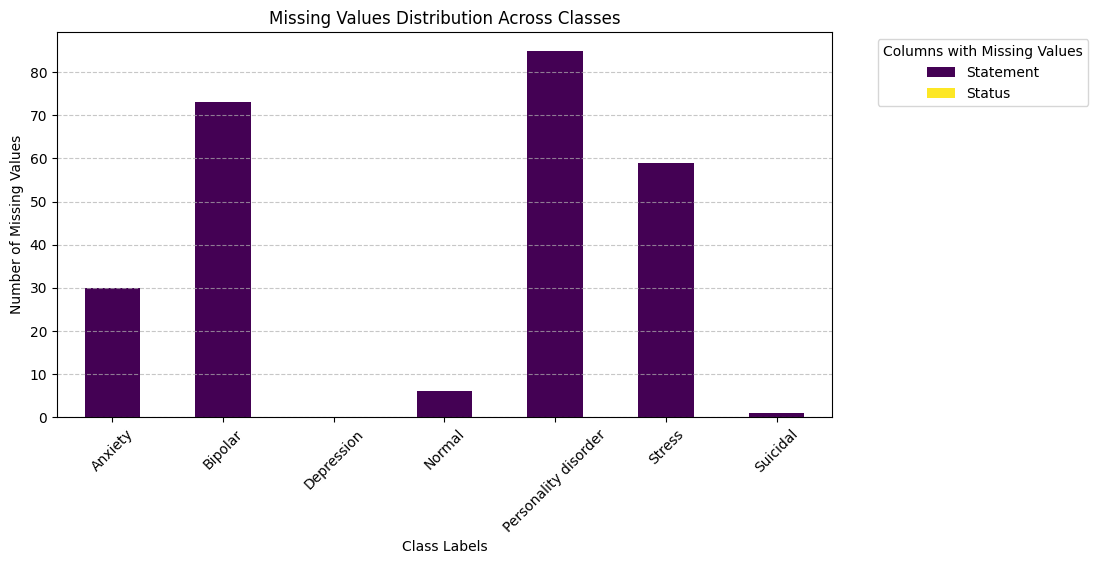

Number of Instances Per Class:
Status
Normal                  11446
Depression              10783
Suicidal                 7457
Anxiety                  2721
Bipolar                  2014
Stress                   1868
Personality disorder      841
Name: count, dtype: int64


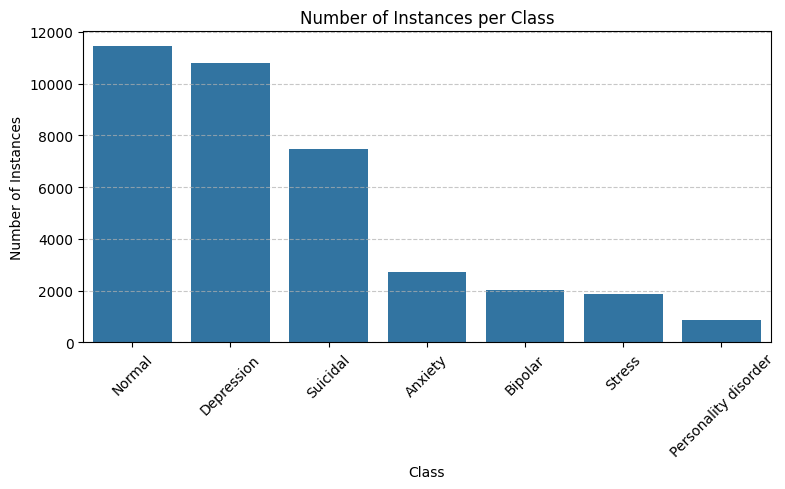

In [4]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


# Load Dataset
df = pd.read_csv("Sentiment_analysis_dataset.csv")
# Inspect Data
print("Dataset Head:")
print(df.head())
print("\nDataset Info:")
print(df.info())


# Check for Missing Values
print("\nMissing Values:")
print(df.isnull().sum())


# Check for missing values per class
missing_values_per_class = df.groupby("Status").apply(lambda x: x.isnull().sum())

# Display missing values per class
print("Missing Values Per Class:")
print(missing_values_per_class)


# Plot Bar Graph
missing_values_per_class.plot(kind='bar', figsize=(10, 5), stacked=True, colormap='viridis')
plt.title("Missing Values Distribution Across Classes")
plt.xlabel("Class Labels")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=45)
plt.legend(title="Columns with Missing Values", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


# Count instances per class
class_counts = df['Status'].value_counts()

# Print number of instances per class
print("Number of Instances Per Class:")
print(class_counts)

# Plot number of instances per class
plt.figure(figsize=(8,5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Number of Instances per Class")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



# Count instances per class
class_counts = df['Status'].value_counts()





# **Step 2: Data preprocessing and Baseline Performance**

Part 1: Cleaning the data


In [3]:
before_drop = df.shape[0]

# Drop rows with missing 'Statement'
df.dropna(subset=['Statement'], inplace=True)
df.reset_index(drop=True, inplace=True)

after_drop = df.shape[0]

print(f"Rows before drop: {before_drop}")
print(f"Rows after drop: {after_drop}")
print(f"Total rows dropped: {before_drop - after_drop}")


# Download stopwords if not already downloaded
nltk.download('stopwords')

port_stem = PorterStemmer()

def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

df['Statement'] = df['Statement'].apply(stemming)

df.head()

# Writing to an Excel file
df.to_excel("stemmed_dataset.xlsx", index=False)





Rows before drop: 37130
Rows after drop: 36876
Total rows dropped: 254


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!




Part 2: Solving the imbalance with different techniques then running logistic regression




In [2]:
###############################################################################
# 1) DATA PREPARATION: LABEL ENCODING & TRAIN/TEST SPLIT
###############################################################################
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df = pd.read_excel("stemmed_dataset.xlsx")

# Assume df is already loaded with columns: 'Status' and 'Statement'
# Encode the target variable
le = LabelEncoder()
df['label'] = le.fit_transform(df['Status'])

# Split the dataset into training and testing sets (using original imbalanced data)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['Statement'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

###############################################################################
# 2) TF-IDF VECTORIZATION (FIT ON TRAINING DATA ONLY)
###############################################################################
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer with a maximum of 5000 features
tfidf = TfidfVectorizer(max_features=5000)

# Fit TF-IDF on the training text and transform both training and test text
X_train_tfidf = tfidf.fit_transform(X_train_text).toarray()
X_test_tfidf = tfidf.transform(X_test_text).toarray()

###############################################################################
# 3) HELPER FUNCTION: EVALUATE MODEL
###############################################################################
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_test, y_test, approach_name):
    """
    Print Accuracy, Classification Report, and plot Confusion Matrix.
    """
    y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"\n[{approach_name}] Accuracy: {acc:.4f}")

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {approach_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

###############################################################################
# 4) BASELINE: NO CLASS BALANCING
###############################################################################
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression model on the training set without any balancing
model_baseline = LogisticRegression(max_iter=1000)
model_baseline.fit(X_train_tfidf, y_train)

# Evaluate the baseline model on the test set
evaluate_model(model_baseline, X_test_tfidf, y_test, "Baseline (No Balancing)")

###############################################################################
# 5) RANDOM OVERSAMPLING (APPLY ON TRAINING DATA ONLY)
###############################################################################
from imblearn.over_sampling import RandomOverSampler

# Apply Random Oversampling only on the training data
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_tfidf, y_train)

# Train the model on the oversampled training data
model_ros = LogisticRegression(max_iter=1000)
model_ros.fit(X_train_ros, y_train_ros)

# Evaluate the oversampled model on the original imbalanced test set
evaluate_model(model_ros, X_test_tfidf, y_test, "Random Oversampling")

###############################################################################
# 6) CLASS WEIGHT BALANCED
###############################################################################
# Train a Logistic Regression model using class_weight='balanced' on the training data
model_cw = LogisticRegression(max_iter=1000, class_weight='balanced')
model_cw.fit(X_train_tfidf, y_train)

# Evaluate the class weight balanced model on the test set
evaluate_model(model_cw, X_test_tfidf, y_test, "Class Weight = 'balanced'")


ValueError: np.nan is an invalid document, expected byte or unicode string.

# **Step 3: Trying Random Forests**

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

#####################################
# Approach 1: Random Oversampling
#####################################

X = tfidf.fit_transform(df['Statement']).toarray()  # Now X is defined
y = df['label']  # And y is defined

# Split the original data first (do not oversample the whole dataset)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply RandomOverSampler only on the training data
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_orig, y_train_orig)

# Train Random Forest on the oversampled training data
rf_ros = RandomForestClassifier(random_state=42)
rf_ros.fit(X_train_ros, y_train_ros)

# Evaluate the model on the original (imbalanced) test set
y_pred_ros = rf_ros.predict(X_test_orig)
print("=== RandomForest with Random Oversampling ===")
print("Accuracy: {:.4f}".format(accuracy_score(y_test_orig, y_pred_ros)))
print("Classification Report:")
print(classification_report(y_test_orig, y_pred_ros, target_names=le.classes_))

# Plot confusion matrix for the oversampling approach
cm_ros = confusion_matrix(y_test_orig, y_pred_ros)
plt.figure(figsize=(6,4))
sns.heatmap(cm_ros, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - RandomForest with Oversampling")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#####################################
# Approach 2: Class Weight Balanced Random Forest
#####################################

# Standard train-test split on the original data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest with class_weight='balanced'
rf_cw = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_cw.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_cw = rf_cw.predict(X_test)
print("\n=== RandomForest with Class Weight 'balanced' ===")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_cw)))
print("Classification Report:")
print(classification_report(y_test, y_pred_cw, target_names=le.classes_))

# Plot confusion matrix for the class weight approach
cm_cw = confusion_matrix(y_test, y_pred_cw)
plt.figure(figsize=(6,4))
sns.heatmap(cm_cw, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - RandomForest with Class Weight 'balanced'")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


NameError: name 'tfidf' is not defined